In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [17]:
def createGreenTaxiDataset(year):
  dfs = []
  for i in range(1,13):
    df = pd.read_parquet(f'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_{year}-{str(i).zfill(2)}.parquet')
    dfs.append(df)
  
  return pd.concat(dfs)

In [18]:
df = createGreenTaxiDataset(2021)

In [19]:
def getTripDuration(df):
  df['duration'] = (df.lpep_dropoff_datetime - df.lpep_pickup_datetime).apply(lambda x: x.total_seconds() / 60)
  return df

In [20]:
df = getTripDuration(df)
df = df.loc[(df.duration > 0) & (df.duration <= 60)]

<Axes: xlabel='duration', ylabel='Count'>

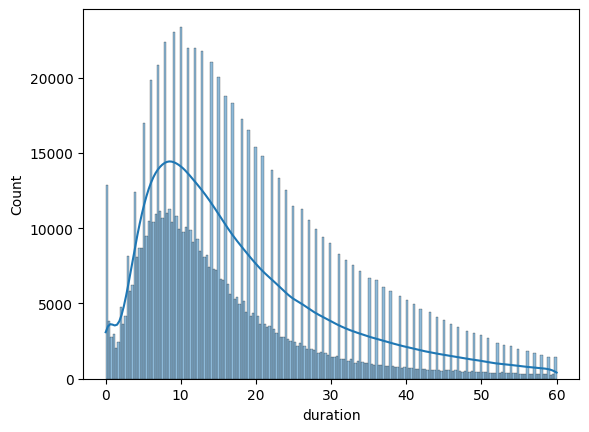

In [21]:
sns.histplot(df, x='duration', kde=True)

In [22]:
def formatTrainingInputs(df):
  df['PU_DO'] = df.PULocationID.astype(str).str.cat(df.DOLocationID.astype(str)) 

  # define input types
  numerical = ['trip_distance']
  categorical = ['PU_DO']
  df[categorical] = df[categorical].astype(str)

  # one-hot encoding for categorical variables
  df_dicts = df[categorical + numerical].to_dict(orient='records')
  dv = DictVectorizer()
  X = dv.fit_transform(df_dicts)

  return X


In [23]:
def prepareModelInputs(df):
  X = formatTrainingInputs(df)
  y = df.duration
  
  splits = train_test_split(X, y, train_size=.7, random_state=42)

  return {
    'X_train': splits[0],
    'X_test': splits[1],
    'y_train': splits[2],
    'y_test': splits[3]
  }

In [24]:
splits = prepareModelInputs(df)

AttributeError: Can only use .str accessor with string values!

In [ ]:
def trainTestModel(model, splits):
  model.fit(splits['X_train'], splits['y_train'])
  y_preds = model.predict(splits['X_test'])
  
  print("Mean Squared Error (test): ", round(mean_squared_error(y_preds, splits['y_test']),2))

  sns.histplot(splits['y_test'], kde=True)
  sns.histplot(y_preds, kde=True)


[14.06790196 13.68229057  9.77839996 ... 21.97845918 13.14328577
 22.85157383]
308805
Mean Squared Error:  116.34


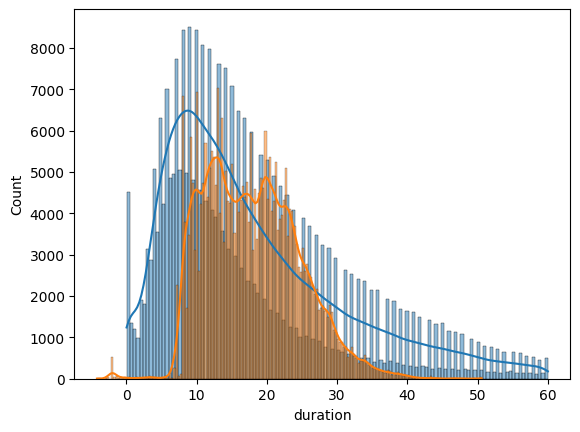

In [ ]:
trainTestModel(LinearRegression(), splits)

[14.06902637 13.68227269  9.78123326 ... 21.97910273 13.14342528
 22.84963876]
308805
Mean Squared Error:  116.34


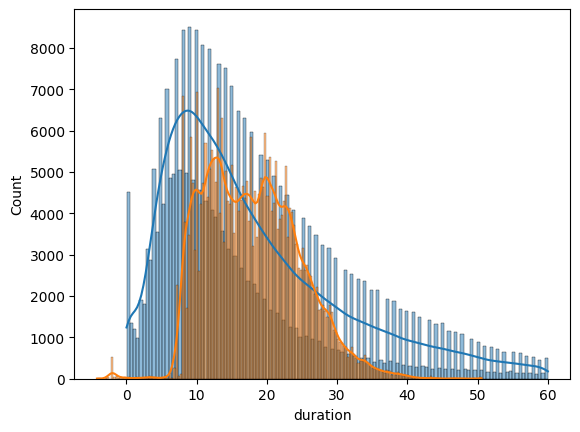

In [ ]:
trainTestModel(Ridge(), splits)